In [886]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

In [2]:
os.getcwd()

'C:\\Users\\nvolf\\Google Drive 2\\5th Year (Masters) Modules\\Third Semester'

# Datasets

## Links
Overview
- (1) has some python related links, I am happy for R, Python, or whatever software/packages
you feel most comfortable with to be used for the duration of the project.
- (2)(3)(4)(5) give you a sense of the underlying data.
- I've done a lot of preprocessing, so in the coming days (don't want to bombard you with too much information on day 1), I'll provide ye
  with a time series which combines (2)/(3)/(4)/(5) into a single time series. Ye can use this directly, or else write your own code
  to include/exclude variables that ye want to include in the model.
- I haven't included the bid-ask curve dataset, I can include that next week if someone is interested in applying the X-Model approach (one of the reference papers).


Things to Think about:
* What exactly am I trying to forecast?
* What are the explanatory variables of interest? Do I include lagged values? How do I choose what variables to include/exclude (this is a research topic in its own right)?
* What modelling approach will I try and mimic?
* What data processing or transforms do I need to apply in order to be able to apply the model?
* What about training/test sets, am I confident that the model isn't under/over fitting? What does the output look like?


1. Python related Book and links
https://machinelearningmastery.com/taxonomy-of-time-series-forecasting-problems/
https://machinelearningmastery.com/start-here/#lstm
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/

2. DAMPrices -> the DAM market price. To recap, an auction occurs at 11am on day D. Then at circa 12pm on day D, the market operator publishes
24 prices, a price for each hour in the interval [11pm D, 10pm D+1]. Info available on SEMOpx. This is ultimately what we want to forecast.

3. BMInfo -> balancing market information. Please note that <b>the data is patchy</b>, this is because with the market go live the systems had issues
with this and other files as the entire software/process was new. <b>Main thing of interest will be the balancing market price</b>. It is for each 30 minute delivery
period. Information available on SEMO. This could be one of the exogenous explanatory variables.

4. WindForecast -> forecast system wind information. This could be one of the exogenous explanatory variables. The information is available via SEMO.
    		   Note: the info I am providing you with is not the raw underlying data file. I have done processing to ensure that we are only including data
                   that would be relevant for modelling.
                   For example, imagine it is 10:59am on day D. I want to forecast prices for every hour in the interval [11pm D, 10pm D+1]. The system wind forecast
		   gets updated throughout the day, but I am only interested in the wind forecast that covers the interval [11pm D, 10pm D+1] that is availabe at 10:59am on day D.
		   This is the information I provide in the file.

5. DemandForecast -> similar comments to (4), except we are dealing with forecast system demand/load.

6. AvailabilityProxy -> If it is 10>59am on day D, and I am about to submit an order to the DAM market, then I am interested in knowing what generators are/aren't available.
			
            This information is published in a couple of different places, but I have yet to source the official files (I've focused my attention on 10-15 of the most important files).
 			
            Hence, what I've done is construct the attached dataset which can be taken as a proxy for the availability. It shows the sell order volumes (in the dataset I don't indicate whether or not the orders were matched), by fuel type, for each hour.
			
            We'll need to be careful with how we use this dataset (I'll discuss the issue when I provide you with a copy of the combined timeseries datasets).



### Load Datasets

In [4]:
path_availability_proxy = "Datasets/AvailabilityProxy.csv"
path_dam_prices = "Datasets/DAMPrices.csv"
path_bm_info = "Datasets/BMInfo.csv"
path_wind_forecast = "Datasets/WindForecast.csv"
path_demand_forecast = "Datasets/DemandForecast.csv"

In [5]:
availability_proxy = pd.read_csv(path_availability_proxy)
dam_prices = pd.read_csv(path_dam_prices)
bm_info = pd.read_csv(path_bm_info)
wind_forecast = pd.read_csv(path_wind_forecast)
demand_forecast = pd.read_csv(path_demand_forecast)

In [6]:
print(availability_proxy.shape)
print(dam_prices.shape)
print(bm_info.shape)
print(wind_forecast.shape)
print(demand_forecast.shape)

(13224, 14)
(13391, 6)
(15000, 5)
(13464, 6)
(13464, 6)


### Check for NAs

In [6]:
print(availability_proxy.isna().sum().sum())
print(dam_prices.isna().sum().sum())
print(bm_info.isna().sum().sum())
print(wind_forecast.isna().sum().sum())
print(demand_forecast.isna().sum().sum())

0
0
6402
0
0


As expected, BM has some missing data.

In [7]:
bm_info.isna().sum()

StartTime             0
EndTime               0
ImbalanceVolume     380
ImbalancePrice        0
ImbalanceCost      6022
dtype: int64

In [206]:
bm_info.shape

(15000, 5)

In [8]:
print(bm_info.isna().any(1).sum())

6022


So majority (6022) of rows with NAs were missing only ImbalanceCost. In particular, rows with NAs are either missing both Volume and Cost or just Cost.

In [9]:
bm_info.head()

,StartTime,EndTime,ImbalanceVolume,ImbalancePrice,ImbalanceCost
0,2018-10-30 23:00:00,2018-10-30 23:30:00,28.997,62.19,NaN
1,2018-10-30 23:30:00,2018-10-31 00:00:00,20.665,49.86,NaN
2,2018-10-31 00:00:00,2018-10-31 00:30:00,19.375,51.94,NaN
3,2018-10-31 00:30:00,2018-10-31 01:00:00,22.803,55.57,NaN
4,2018-10-31 01:00:00,2018-10-31 01:30:00,15.890,49.24,NaN


### Date ranges of datasets

In [12]:
datasets = ["Availability Proxy", "DAM Prices", "BM Info", "Wind Forecast", "Demand Forecast"]
time_from = [availability_proxy.loc[:,"PeriodDateTimes"].min(),
            dam_prices.loc[:, "AuctionDateTime"].min(),
            bm_info.iloc[0,0],
            wind_forecast.iloc[0,1],
            demand_forecast.iloc[-1,2]]
time_to = [availability_proxy.loc[:,"PeriodDateTimes"].max(),
          dam_prices.loc[:, "AuctionDateTime"].max(),
          bm_info.iloc[-1,1],
          wind_forecast.iloc[-1,2],
          demand_forecast.iloc[-1,2]]

pd.DataFrame(dict(Dataset=datasets, From=time_from, To=time_to))

,Dataset,From,To
0,Availability Proxy,2018-11-09 23:00:00,2020-05-13 22:00:00
1,DAM Prices,2018-11-11 11:00:00,2020-05-21 11:00:00
2,BM Info,2018-10-30 23:00:00,2019-09-02 22:00:00
3,Wind Forecast,2018-11-08 23:00:00,2020-05-22 22:15:00
4,Demand Forecast,2020-05-22 22:30:00,2020-05-22 22:30:00


### Initial plots

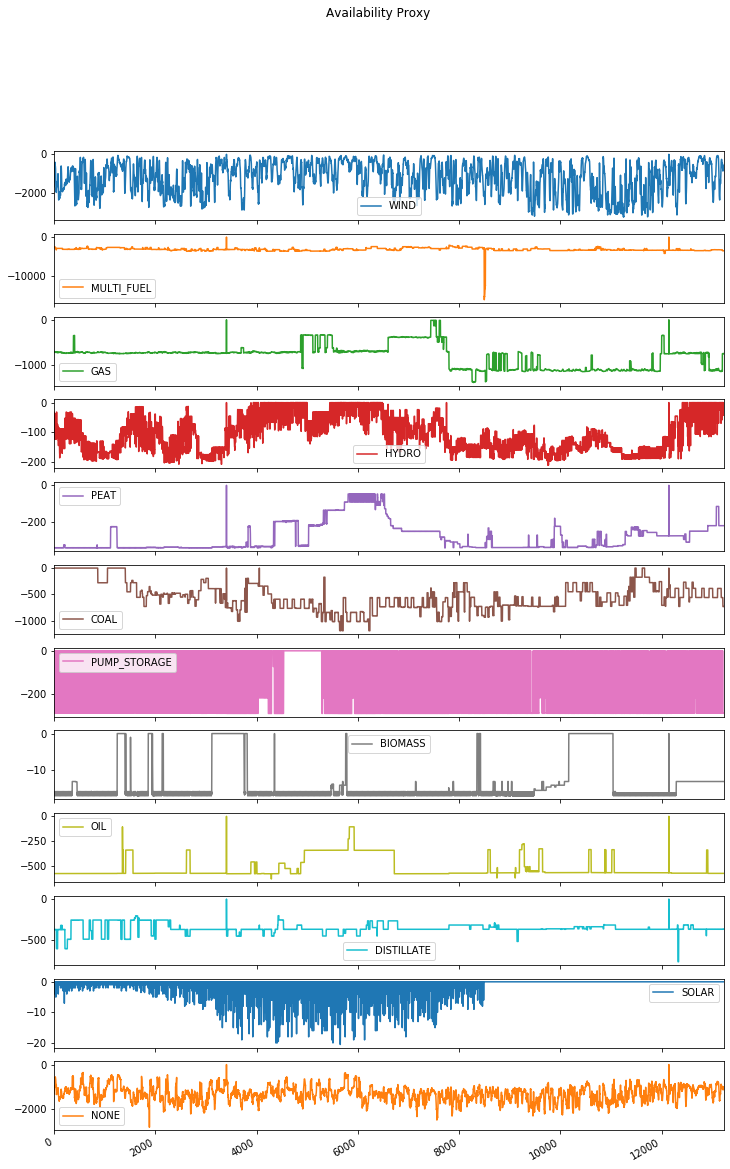

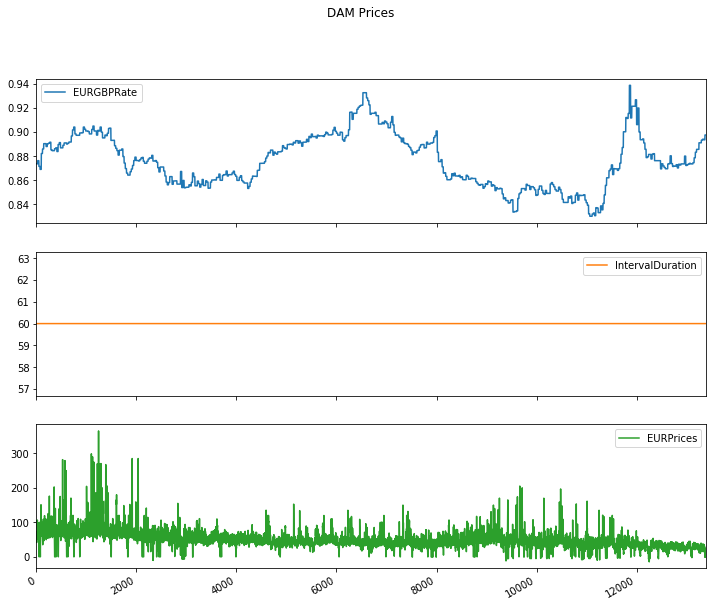

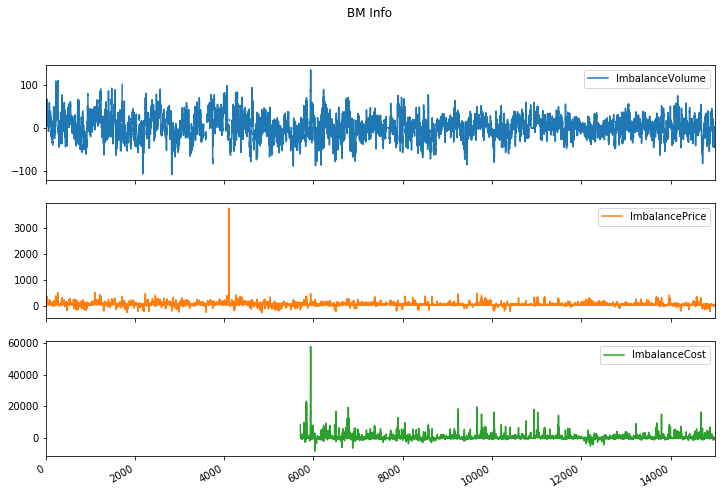

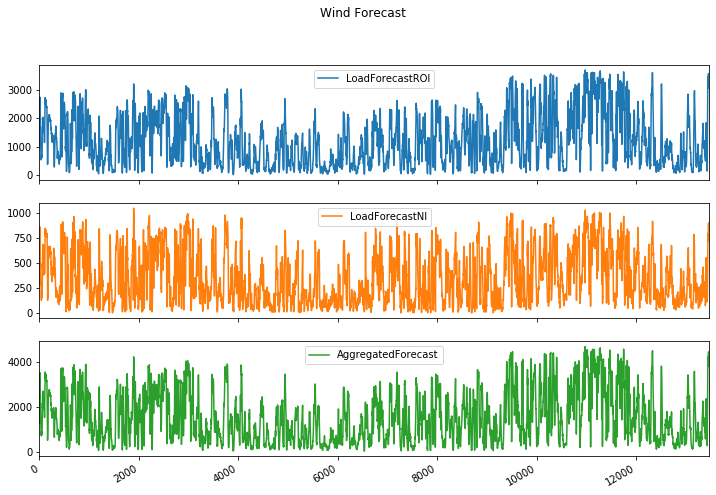

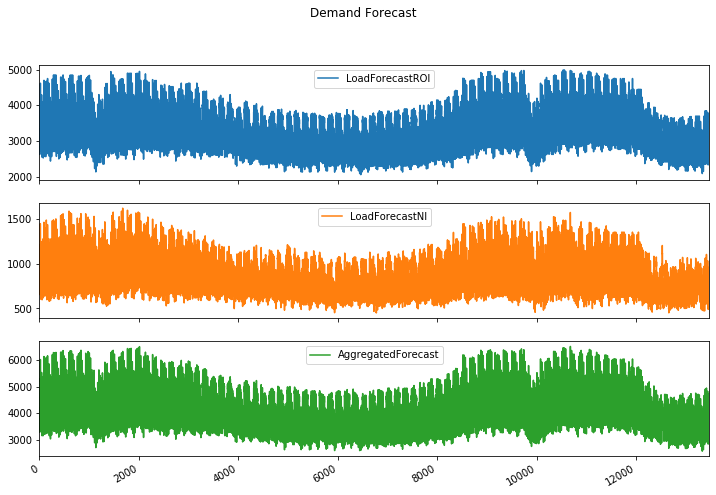

In [13]:
%matplotlib inline
availability_proxy.drop(["index", "PeriodDateTimes"], axis=1).plot(subplots=True, figsize=(12,20),
                                                                  title="Availability Proxy")

dam_prices.drop(["AreaSet", "AuctionDateTime", "DeliveryPeriod"], axis=1).plot(subplots=True, figsize=(12,10),
                                                                              title="DAM Prices")

bm_info.drop(["StartTime", "EndTime"], axis=1).plot(subplots=True, figsize=(12,8), title="BM Info")

wind_forecast.drop(["PublishTime", "StartTime", "EndTime"], axis=1).plot(subplots=True, figsize=(12,8),
                                                                        title="Wind Forecast")

demand_forecast.drop(["PublishTime", "StartTime", "EndTime"], axis=1).plot(subplots=True, figsize=(12,8),
                                                                          title="Demand Forecast")

plt.show()

Imbalance peaks (once) at index 4107

In [ ]:
imbalance_price_max = bm_info.max()["ImbalancePrice"]
bm_info.loc[bm_info.loc[:,"ImbalancePrice"] == imbalance_price_max,:]

In [18]:
bm_info.loc[4104:4110,:]

,StartTime,EndTime,ImbalanceVolume,ImbalancePrice,ImbalanceCost
4104,2019-01-24 11:30:00,2019-01-24 12:00:00,6.481,1331.37,NaN
4105,2019-01-24 12:00:00,2019-01-24 12:30:00,-0.386,53.00,NaN
4106,2019-01-24 12:30:00,2019-01-24 13:00:00,-11.838,980.56,NaN
4107,2019-01-24 13:00:00,2019-01-24 13:30:00,-14.602,3773.69,NaN
4108,2019-01-24 13:30:00,2019-01-24 14:00:00,-17.398,1909.45,NaN
4109,2019-01-24 14:00:00,2019-01-24 14:30:00,-9.412,329.69,NaN
4110,2019-01-24 14:30:00,2019-01-24 15:00:00,1.084,45.09,NaN


In [203]:
imbalance_cost_max = bm_info.max()["ImbalanceCost"]
bm_info.loc[bm_info.loc[:,"ImbalanceCost"] == imbalance_cost_max,:]

,StartTime,EndTime,ImbalanceVolume,ImbalancePrice,ImbalanceCost
5937,2019-03-03 18:00:00,2019-03-03 18:30:00,124.517,464.34,57818.22378


In [204]:
bm_info.loc[5935:5940,:]

,StartTime,EndTime,ImbalanceVolume,ImbalancePrice,ImbalanceCost
5935,2019-03-03 17:00:00,2019-03-03 17:30:00,109.201,295.16,32231.76716
5936,2019-03-03 17:30:00,2019-03-03 18:00:00,122.472,464.75,56918.86200
5937,2019-03-03 18:00:00,2019-03-03 18:30:00,124.517,464.34,57818.22378
5938,2019-03-03 18:30:00,2019-03-03 19:00:00,134.111,388.24,52067.25464
5939,2019-03-03 19:00:00,2019-03-03 19:30:00,115.935,429.91,49841.61585
5940,2019-03-03 19:30:00,2019-03-03 20:00:00,80.770,303.84,24541.15680


,StartTime,EndTime,ImbalanceVolume,ImbalancePrice,ImbalanceCost
4107,2019-01-24 13:00:00,2019-01-24 13:30:00,-14.602,3773.69,NaN


### Electricity Price

In [183]:
electricity_prices.shape[0]

13391

In [187]:
electricity_prices = dam_prices[["EURPrices"]]
electricity_prices.index = dam_prices[["DeliveryPeriod"]]

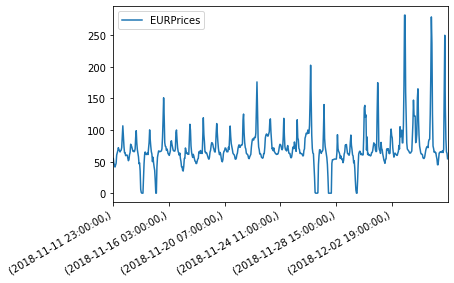

In [193]:
%matplotlib inline
electricity_prices[0:600].plot(subplots=True)
plt.show()